# Forecasting Diagnostics & Visual Review

Reproduces and extends the forecasting workflow from `oxygen_forecasting_model_tvt.ipynb` using three datasets:

- `data/oxygen_processed_full.csv` (processed training data with anomaly features)
- `data/oxygen_sample_forecast.csv` (scored + 1-step forecasts on sample data)
- `data/forecast_1week_SubUnit_07.csv` (1-week horizon forecast for a sensor)

Goals:
- Compare actual vs predicted values and quantify errors.
- Visualize performance over time with zoomed windows.
- Inspect forecast quality for both immediate 1-step predictions and the 1-week horizon.


In [1]:
import os
import json
from pathlib import Path
from typing import Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)


In [2]:
# Select a specific sensor to visualize
SELECTED_SENSOR_ID = "SubUnit_07"


In [3]:
from typing import Iterable

# Resolve data directories relative to this notebook location
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
DATA_RAW_DIR = Path(os.path.join(DATA_DIR, 'processed'))


def optional_read(paths: Iterable[Path | str], **kwargs):
    for p in paths:
        p = Path(p)
        if p.exists():
            print(f"Loaded {p}")
            return pd.read_csv(p, **kwargs)
    print(f"[WARN] None of the candidate paths exist: {paths}")
    return None


data_paths = {
    'processed_full': [DATA_RAW_DIR / 'oxygen_processed_full.csv', Path(DATA_DIR) / 'oxygen_processed_full.csv'],
    'sample_forecast': [DATA_RAW_DIR / 'oxygen_sample_forecast.csv', Path(DATA_DIR) / 'oxygen_sample_forecast.csv'],
    'forecast_1week': [DATA_RAW_DIR / 'forecast_1week_SubUnit_07.csv', Path(DATA_DIR) / 'forecast_1week_SubUnit_07.csv'],
}

# Load datasets (optional) and ensure datetime parsing when present
df_processed = optional_read(data_paths['processed_full'])
if df_processed is not None:
    df_processed = df_processed.assign(time=lambda d: pd.to_datetime(d['time']))
else:
    df_processed = pd.DataFrame(columns=['time', 'oxygen', 'severity', 'sensor_id'])

df_sample = optional_read(data_paths['sample_forecast'])
if df_sample is not None:
    df_sample = df_sample.assign(time=lambda d: pd.to_datetime(d['time']))
else:
    df_sample = pd.DataFrame(columns=['time', 'oxygen', 'y_pred', 'sensor_id'])

df_forecast = optional_read(data_paths['forecast_1week'])
if df_forecast is not None:
    df_forecast = df_forecast.assign(time=lambda d: pd.to_datetime(d['time']))
else:
    df_forecast = pd.DataFrame(columns=['time', 'sensor_id', 'forecast'])

print('Shapes:')
print('processed_full:', df_processed.shape)
print('sample_forecast:', df_sample.shape)
print('forecast_1week:', df_forecast.shape)


# Filter to selected sensor where applicable
if 'sensor_id' in df_processed.columns and not df_processed.empty:
    df_processed = df_processed[df_processed['sensor_id'].astype(str).str.contains(SELECTED_SENSOR_ID, na=False)]
if 'sensor_id' in df_sample.columns and not df_sample.empty:
    df_sample = df_sample[df_sample['sensor_id'].astype(str).str.contains(SELECTED_SENSOR_ID, na=False)]
if 'sensor_id' in df_forecast.columns and not df_forecast.empty:
    df_forecast = df_forecast[df_forecast['sensor_id'].astype(str).str.contains(SELECTED_SENSOR_ID, na=False)]

# Warn if no matching rows
if df_processed.empty:
    print(f"[WARN] No rows for sensor_id containing '{SELECTED_SENSOR_ID}' in processed data")
if df_sample.empty:
    print(f"[WARN] No rows for sensor_id containing '{SELECTED_SENSOR_ID}' in sample forecast")
if df_forecast.empty:
    print(f"[WARN] No rows for sensor_id containing '{SELECTED_SENSOR_ID}' in 1-week forecast")


Loaded /Users/musarratrahman/Documents/anomaly_detection_and_forecasting_solution/data/processed/oxygen_processed_full.csv


/var/folders/8s/sjvvckvj2vz01k8kms4ryh_80000gn/T/ipykernel_34998/4082129439.py:13: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(p, **kwargs)


Loaded /Users/musarratrahman/Documents/anomaly_detection_and_forecasting_solution/data/processed/oxygen_sample_forecast.csv
Loaded /Users/musarratrahman/Documents/anomaly_detection_and_forecasting_solution/data/processed/forecast_1week_SubUnit_07.csv
Shapes:
processed_full: (1596212, 35)
sample_forecast: (1949, 36)
forecast_1week: (10080, 3)


## Quick previews
Peek at the first few rows to confirm schema and ensure expected columns are present.

In [4]:
if not df_processed.empty:
    display(df_processed.head())
else:
    print('processed_full not available for selected sensor')

if not df_sample.empty:
    display(df_sample.head())
else:
    print('sample_forecast not available for selected sensor')

if not df_forecast.empty:
    display(df_forecast.head())
else:
    print('forecast_1week not available for selected sensor')


,time,oxygen,EquipmentUnit,SubUnit,System,Unit,sensor_id,hour,dayofweek,roll_mean,...,severity,minute_of_day,sin_time,cos_time,sin_dow,cos_dow,lag_1,lag_5,lag_60,roll_mean_60
635219,2025-04-01 18:43:00,87.789536,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,18,1,89.470375,...,0.0,1123,-0.982450,0.186524,0.781831,0.62349,89.022537,86.655136,90.521339,89.470375
635220,2025-04-01 18:44:00,88.528511,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,18,1,89.420526,...,0.0,1124,-0.981627,0.190809,0.781831,0.62349,87.789536,88.234253,91.519485,89.420526
635221,2025-04-01 18:45:00,87.037125,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,18,1,89.368930,...,0.0,1125,-0.980785,0.195090,0.781831,0.62349,88.528511,89.000282,90.132881,89.368930
635222,2025-04-01 18:46:00,88.862930,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,18,1,89.312199,...,0.0,1126,-0.979925,0.199368,0.781831,0.62349,87.037125,87.732956,92.266747,89.312199
635223,2025-04-01 18:47:00,87.527489,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,18,1,89.305039,...,0.0,1127,-0.979045,0.203642,0.781831,0.62349,88.862930,89.022537,87.957130,89.305039


,time,oxygen,EquipmentUnit,SubUnit,System,Unit,sensor_id,hour,dayofweek,roll_mean,...,minute_of_day,sin_time,cos_time,sin_dow,cos_dow,lag_1,lag_5,lag_60,roll_mean_60,y_pred
826,2025-05-08 22:50:00,87.101845,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,22,3,87.209576,...,1370,-0.300706,0.953717,0.433884,-0.900969,85.170723,88.783936,88.394341,87.209576,86.257254
827,2025-05-09 12:13:00,83.390923,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,12,4,87.058677,...,733,-0.056693,-0.998392,-0.433884,-0.900969,87.101845,80.914261,92.444878,87.058677,86.289156
828,2025-05-10 06:54:00,84.389931,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,6,5,86.951442,...,414,0.972370,-0.233445,-0.974928,-0.222521,83.390923,86.329559,90.824013,86.951442,84.556397
829,2025-05-10 23:04:00,85.419991,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,23,5,86.863906,...,1384,-0.241922,0.970296,-0.974928,-0.222521,84.389931,84.244881,90.672142,86.863906,84.584293
830,2025-05-12 08:20:00,84.172981,EquipmentUnit_10,SubUnit_07,System_10,Unit_01,System_10|EquipmentUnit_10|SubUnit_07,8,0,86.961805,...,500,0.819152,-0.573576,0.000000,1.000000,85.419991,85.170723,78.299034,86.961805,85.512851


,time,sensor_id,forecast
0,2025-11-14 09:32:00,System_10|EquipmentUnit_10|SubUnit_07,83.616112
1,2025-11-14 09:33:00,System_10|EquipmentUnit_10|SubUnit_07,83.616112
2,2025-11-14 09:34:00,System_10|EquipmentUnit_10|SubUnit_07,83.576666
3,2025-11-14 09:35:00,System_10|EquipmentUnit_10|SubUnit_07,83.584673
4,2025-11-14 09:36:00,System_10|EquipmentUnit_10|SubUnit_07,83.610020


## Helper plotting utilities

In [5]:
def plot_actual_vs_predicted(df: pd.DataFrame, value_col: str = 'oxygen', pred_col: str = 'y_pred', title: str = '', start: Optional[pd.Timestamp] = None, end: Optional[pd.Timestamp] = None):
    window = df
    if start is not None:
        window = window[window['time'] >= start]
    if end is not None:
        window = window[window['time'] <= end]
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(window['time'], window[value_col], label='actual', linewidth=1.2)
    ax.plot(window['time'], window[pred_col], label='predicted', linewidth=1.1, alpha=0.8)
    ax.set_title(title or 'Actual vs predicted')
    ax.set_xlabel('time')
    ax.set_ylabel(value_col)
    ax.legend()
    plt.xticks(rotation=20)
    plt.show()


def plot_residuals(residuals: pd.Series, title: str = 'Residuals'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(residuals, bins=40, alpha=0.8, color='steelblue', edgecolor='white')
    axes[0].set_title(f"{title} distribution")
    axes[0].set_xlabel('residual')
    axes[0].set_ylabel('count')

    axes[1].scatter(np.arange(len(residuals)), residuals, s=10, alpha=0.8, color='darkorange')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1].set_title(f"{title} over time index")
    axes[1].set_xlabel('index')
    axes[1].set_ylabel('residual')
    plt.tight_layout()
    plt.show()


## Sample forecast: actual vs predicted (1-step ahead)
We use `data/processed/oxygen_sample_forecast.csv` which already contains `y_pred`.

MAE:  2.532
RMSE: 3.500
MAPE: 3.08%


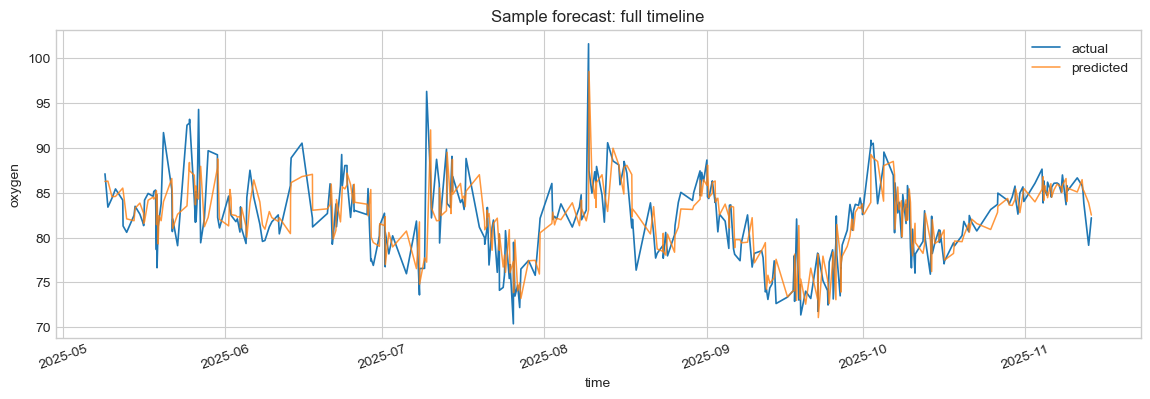

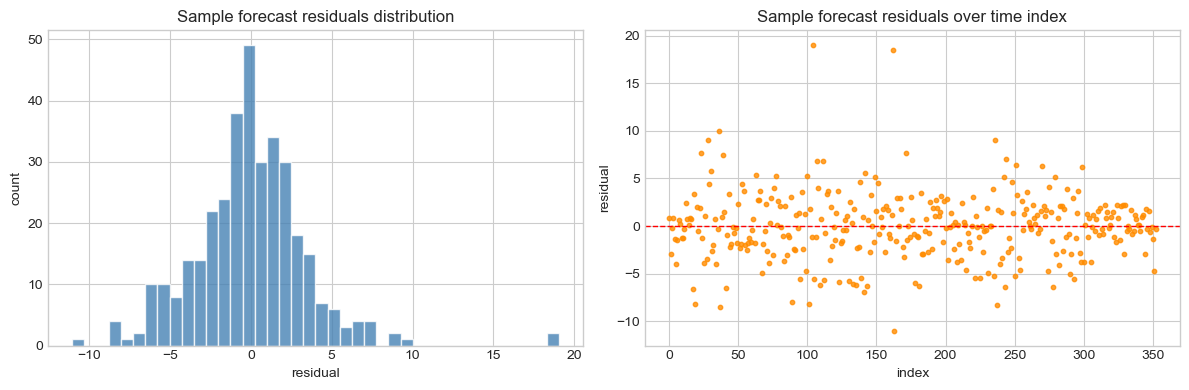

In [6]:
value_col = 'oxygen'
pred_col = 'y_pred'

if df_sample.empty or pred_col not in df_sample.columns:
    print('sample_forecast not available or missing predictions; skipping evaluation plots.')
else:
    sample_eval = df_sample.dropna(subset=[pred_col]).copy()
    sample_eval['residual'] = sample_eval[value_col] - sample_eval[pred_col]

    mae = sample_eval['residual'].abs().mean()
    rmse = np.sqrt((sample_eval['residual'] ** 2).mean())
    mape = (sample_eval['residual'].abs() / sample_eval[value_col].replace(0, np.nan)).mean() * 100

    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")

    plot_actual_vs_predicted(sample_eval, value_col=value_col, pred_col=pred_col, title='Sample forecast: full timeline')

    if len(sample_eval) > 500:
        plot_actual_vs_predicted(sample_eval.tail(500), value_col=value_col, pred_col=pred_col, title='Sample forecast: last 500 points')

    plot_residuals(sample_eval['residual'], title='Sample forecast residuals')


## Train/Valid/Test boundaries on processed data
We overlay split markers (from `models/baseline_stats.json` if available) on the raw signal + severity to inspect data distribution across splits.

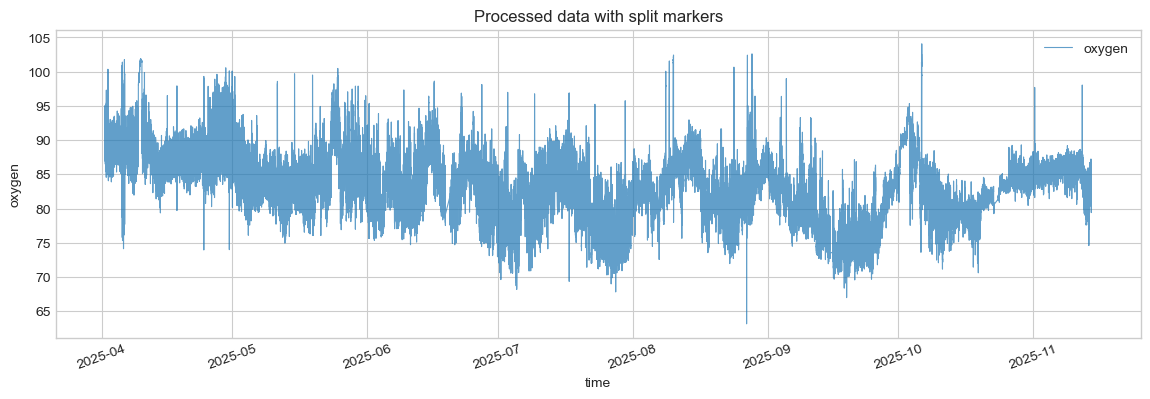

In [7]:
baseline_stats_path = Path('models/baseline_stats.json')
valid_start = test_start = None
if baseline_stats_path.exists():
    with open(baseline_stats_path, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    valid_start = pd.to_datetime(stats.get('valid_start')) if stats.get('valid_start') else None
    test_start = pd.to_datetime(stats.get('test_start')) if stats.get('test_start') else None
    display(stats)

if df_processed.empty:
    print('processed_full not available for selected sensor; skipping split visualization.')
else:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df_processed['time'], df_processed['oxygen'], label='oxygen', linewidth=0.8, alpha=0.7)
    ax.set_title('Processed data with split markers')
    if valid_start is not None:
        ax.axvline(valid_start, color='orange', linestyle='--', label='valid_start')
    if test_start is not None:
        ax.axvline(test_start, color='red', linestyle='--', label='test_start')
    ax.set_xlabel('time')
    ax.set_ylabel('oxygen')
    ax.legend()
    plt.xticks(rotation=20)
    plt.show()


## Severity vs oxygen (zoomed window)
Helps spot outlier regions that were filtered out for training.

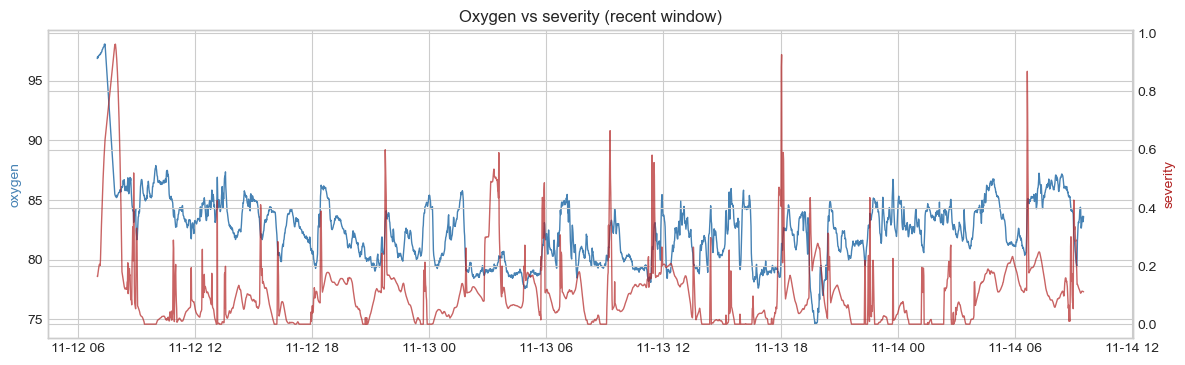

In [8]:
if df_processed.empty:
    print('processed_full not available for selected sensor; skipping severity plot.')
else:
    recent_window = df_processed.tail(3000)
    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax1.plot(recent_window['time'], recent_window['oxygen'], label='oxygen', color='steelblue', linewidth=1.0)
    ax1.set_ylabel('oxygen', color='steelblue')
    ax2 = ax1.twinx()
    if 'severity' in recent_window.columns:
        ax2.plot(recent_window['time'], recent_window['severity'], label='severity', color='firebrick', linewidth=1.0, alpha=0.7)
    ax2.set_ylabel('severity', color='firebrick')
    ax1.set_title('Oxygen vs severity (recent window)')
    plt.xticks(rotation=20)
    plt.show()


## 1-week horizon continuation for a specific sensor
We join the tail of historical oxygen values with the 1-week forecast to visually assess continuity.

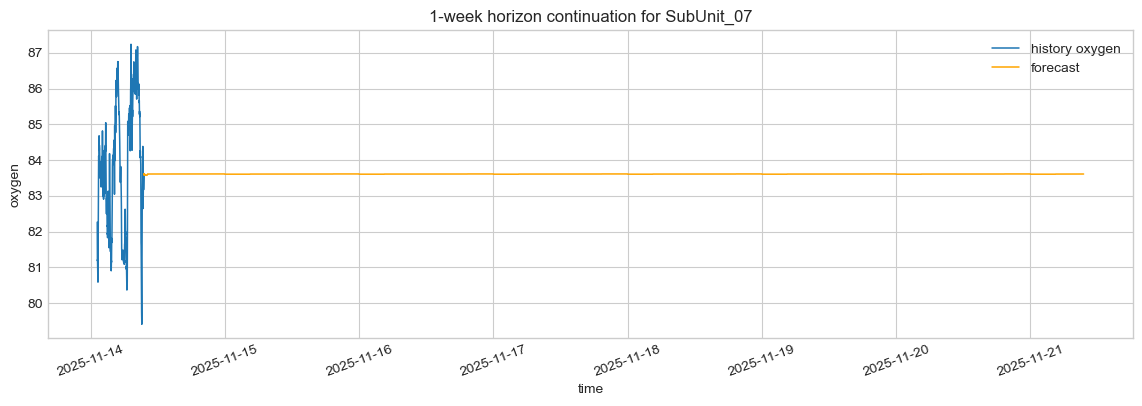

In [9]:
if df_forecast.empty:
    print('forecast_1week not available for selected sensor; skipping horizon overlay.')
else:
    sensor_id_focus = SELECTED_SENSOR_ID
    recent_history = df_processed[df_processed.get('sensor_id', pd.Series(dtype=str)).astype(str).str.contains(SELECTED_SENSOR_ID, na=False)].tail(500).copy()
    forecast_plot = df_forecast.copy()

    fig, ax = plt.subplots(figsize=(14, 4))
    if not recent_history.empty:
        ax.plot(recent_history['time'], recent_history['oxygen'], label='history oxygen', linewidth=1.1)
    ax.plot(forecast_plot['time'], forecast_plot['forecast'], label='forecast', linewidth=1.1, color='orange')
    ax.set_title(f'1-week horizon continuation for {sensor_id_focus}')
    ax.set_xlabel('time')
    ax.set_ylabel('oxygen')
    ax.legend()
    plt.xticks(rotation=20)
    plt.show()
